In [1]:
import os
import torch
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, Tuple, Optional, List

In [2]:
os.chdir('..') # change working directory to root

In [3]:
from agents.td3 import TD3
from agents.d3qn import D3QN
from mdp.mimic_iii.reward_functions.abstract_reward_function import AbstractRewardFunction
from mdp.mimic_iii.reward_functions.factory import Factory as RewardFnFactory
from mdp.mimic_iii.action_spaces.discrete import Discrete as DiscreteActionSpace
from mdp.mimic_iii.state_spaces.sparse_autoencoder import SparseAutoEncoder as MimicIIISparseAutoEncoderStateSpace
from ope.behavior_policies.kmeans_sarsa import KMeansSarsa
from utilities import mimic_iii_funcs
from utilities.device_manager import DeviceManager

In [4]:
# reward function details dict
reward_fn_details_dict = {
    'sparse': {
        'mlflow_base_path': '<your_base_path>/mimic-iii_reward_fn_eval/vm/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '97629e709d7f45ec851200c6b0d497df',
        'd3qn_run_id': '5944007810ef4e318106533adbd6ccb6',
        'd3qn_magic_run_id': '85de6b80c8374e489bb49164bcbf29a5',
        'ddpg_run_id': 'cba965ed952945a1a0d9660d807cf2a0',
        'ddpg_magic_run_id': 'f835cde18011478693931ecc0247df63',
    },
    'wu': {
        'mlflow_base_path': '<your_base_path>/mimic-iii_reward_fn_eval/0/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '6dd75e96646b45938f225f3964705324',
        'd3qn_run_id': '5d140bdb06e344bd888876561f010f0e',
        'd3qn_magic_run_id': 'fd3f75118286426f88ca127246e33cda',
        'ddpg_run_id': '67c02a6bab0b4d74aadf585f7c8edd87',
        'ddpg_magic_run_id': '18ed010dada041f79639230d54ca5db7',
    },
    'yong': {
        'mlflow_base_path': '<your_base_path>/mimic-iii_reward_fn_eval/0/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': 'ecac4334f1994260b2bcd420b671c53a',
        'd3qn_run_id': '8f098fb13a5b41da9e77dac2ae13d321',
        'd3qn_magic_run_id': '29ad84ac64ed4ab98f7e10488887f301',
        'ddpg_run_id': '30cccf0e3c2c4ffaa1a9ea1c2bf23972',
        'ddpg_magic_run_id': '7ecad48fb0e04388b048d183b195e5f8',
    },
    'raghu': {
        'mlflow_base_path': '<your_base_path>/mimic-iii_reward_fn_eval/1/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '17d5de3272cb4e2892e6e438d22c2af4',
        'd3qn_run_id': '9a5d00e3454840499ce4697fa6bf472c',
        'd3qn_magic_run_id': 'd2584eef61284bc4bc9d57402927b750',
        'ddpg_run_id': 'da45045dfb1042d1a21a06360ca55239',
        'ddpg_magic_run_id': '01c5faa0f8ee4a5b9cb08a712060dc0e',
    },
    'peng': {
        'mlflow_base_path': '<your_base_path>/mimic-iii_reward_fn_eval/1/mlruns',
        'state_space_run_id': 'd5233d8c966846b0b01406a162c26fe7',
        'behavior_policy_run_id': '1e6330b7604f4aad8da905239c1b5070',
        'd3qn_run_id': '37d3ea87328d4c94a75c5d6e0011495a',
        'd3qn_magic_run_id': '68161afeb1ff41bbbc795f91e6a42c5b',
        'ddpg_run_id': 'b008b48ce39d4847ae2d377b4cbb91ba',
        'ddpg_magic_run_id': '2d6c08b95c8e40c2a6a0473a3b12f737',
        'reward_fn_run_id': '211c5a3c31f147f38d63b6b357a7b610',
    },
}

In [20]:
def d3qn_agent_eval(d3qn_agent_: D3QN, dataloader: torch.utils.data.DataLoader, cont_state_space_ae: MimicIIISparseAutoEncoderStateSpace) -> np.ndarray:
    all_eval_actions = None
    with torch.no_grad():
        for i, (states, actions, next_states, rewards, dones) in enumerate(dataloader):
            states = cont_state_space_ae.encode(states).detach()
            cur_actions, _ = d3qn_agent_.get_best_action(states)
            if all_eval_actions is None:
                all_eval_actions = cur_actions.action
            else:
                all_eval_actions = torch.cat((all_eval_actions, cur_actions.action), dim=0)
    all_eval_actions = all_eval_actions.cpu().numpy()
    np_vec_fn_to_fluid = np.vectorize(lambda x: DiscreteActionSpace.Extract_IV_Fluids_From_Action(int(x)))
    np_vec_fn_to_vaso = np.vectorize(lambda x: DiscreteActionSpace.Extract_VP_From_Action(int(x)))
    iv_actions = np_vec_fn_to_fluid(all_eval_actions)
    vaso_actions = np_vec_fn_to_vaso(all_eval_actions)
    action_counts = extract_action_count_matrix(iv_actions, vaso_actions)
    return action_counts

def ddpg_agent_eval(ddpg_agent_: TD3, dataloader: torch.utils.data.DataLoader, cont_state_space_ae: MimicIIISparseAutoEncoderStateSpace, return_discrete_actions: bool, action_scaler: MinMaxScaler) -> np.ndarray | torch.FloatTensor:
    all_eval_actions = None
    with torch.no_grad():
        for i, (states, actions, next_states, rewards, dones) in enumerate(dataloader):
            states = cont_state_space_ae.encode(states).detach()
            cur_actions, _ = ddpg_agent_.get_best_action(states)
            cur_actions = torch.from_numpy(action_scaler.inverse_transform(cur_actions.action.cpu().numpy())).float()
            # if return_discrete_actions:
            #     cur_discrete_actions = DiscreteActionSpace.Continuous_Tensor_To_Discrete_Tensor(cur_actions)
            #     # # convert actions to discrete
            #     # cur_discrete_actions = torch.empty(cur_actions.shape[0], dtype=torch.long, device=cur_actions.device)
            #     # for i in range(cur_actions.shape[0]):
            #     #     cur_val = cur_actions[i].cpu()
            #     #     cur_discrete_actions[i] = DiscreteActionSpace.Continuous_To_Discrete(cur_val[0].item(), cur_val[1].item()).value
            #     cur_actions = cur_discrete_actions
            if all_eval_actions is None:
                all_eval_actions = cur_actions
            else:
                all_eval_actions = torch.cat((all_eval_actions, cur_actions), dim=0)
    if return_discrete_actions:
        iv_actions = DiscreteActionSpace.Continuous_IV_Fluids_Tensor_To_Discrete_Tensor(all_eval_actions[:, 0]).cpu().numpy()
        vaso_actions = DiscreteActionSpace.Continuous_VP_Tensor_To_Discrete_Tensor(all_eval_actions[:, 1]).cpu().numpy()
        action_counts = extract_action_count_matrix(iv_actions, vaso_actions)
        return action_counts
    else:
        return all_eval_actions

def load_split_agent_test_data(split_: int, reward_fn_name_: str, reward_fn: AbstractRewardFunction, batch_size: int = 512) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader, Tuple[Optional[float], Optional[float]], Tuple[Optional[float], Optional[float]], float, MinMaxScaler]:
    # load and preprocess mimic data
    discrete_mimic_df = mimic_iii_funcs.load_standardized_mimic_data(split_, reward_fn.raw_data_columns)
    if reward_fn_name_ != 'peng':
        reward_fn.update_rewards(discrete_mimic_df)  # scale rewards
        discrete_mimic_df = mimic_iii_funcs.drop_all_raw_data_columns(discrete_mimic_df)
    continuous_mimic_df = discrete_mimic_df.copy()
    discrete_mimic_df, discrete_min_max_scaler, _ = mimic_iii_funcs.preprocess_mimic_data(discrete_mimic_df, 'iql_discrete')
    continuous_mimic_df, continuous_min_max_scaler, action_min_max_scaler = mimic_iii_funcs.preprocess_mimic_data(continuous_mimic_df, 'ddpg_cont')
    if reward_fn_name_ == 'peng':
        reward_fn.update_rewards(discrete_mimic_df)  # scale rewards
        reward_fn.update_rewards(continuous_mimic_df)
    max_reward_ = discrete_mimic_df['r:reward'].abs().max()
    action_mins_, action_maxs_ = mimic_iii_funcs.get_cont_action_space_bounds(continuous_mimic_df)
    # discrete split
    (
        (discrete_train_states, discrete_train_actions, discrete_train_next_states, discrete_train_rewards, discrete_train_dones),
        (discrete_val_states, discrete_val_actions, discrete_val_next_states, discrete_val_rewards, discrete_val_dones),
        (discrete_test_states, discrete_test_actions, discrete_test_next_states, discrete_test_rewards, discrete_test_dones)
    ) = mimic_iii_funcs.train_val_test_split_mimic_data(discrete_mimic_df, 'iql_discrete')
    # continuous split
    (
        (continuous_train_states, continuous_train_actions, continuous_train_next_states, continuous_train_rewards, continuous_train_dones),
        (continuous_val_states, continuous_val_actions, continuous_val_next_states, continuous_val_rewards, continuous_val_dones),
        (continuous_test_states, continuous_test_actions, continuous_test_next_states, continuous_test_rewards, continuous_test_dones)
    ) = mimic_iii_funcs.train_val_test_split_mimic_data(continuous_mimic_df, 'ddpg_cont')
    # create discrete dataloaders
    # discrete_train_dataset = mimic_iii_funcs.ImplicitQLearningDataset(discrete_train_states, discrete_train_actions, discrete_train_next_states, discrete_train_rewards, discrete_train_dones)
    # discrete_train_dataloader = torch.utils.data.DataLoader(discrete_train_dataset, batch_size=batch_size, shuffle=False)
    # discrete_val_dataset = mimic_iii_funcs.ImplicitQLearningDataset(discrete_val_states, discrete_val_actions, discrete_val_next_states, discrete_val_rewards, discrete_val_dones)
    # discrete_val_dataloader = torch.utils.data.DataLoader(discrete_val_dataset, batch_size=batch_size, shuffle=False)
    discrete_test_dataset = mimic_iii_funcs.ImplicitQLearningDataset(discrete_test_states, discrete_test_actions, discrete_test_next_states, discrete_test_rewards, discrete_test_dones)
    discrete_test_dataloader_ = torch.utils.data.DataLoader(discrete_test_dataset, batch_size=batch_size, shuffle=False)
    # create continuous dataloaders
    # continuous_train_dataset = mimic_iii_funcs.ImplicitQLearningDataset(continuous_train_states, continuous_train_actions, continuous_train_next_states, continuous_train_rewards, continuous_train_dones)
    # continuous_train_dataloader = torch.utils.data.DataLoader(continuous_train_dataset, batch_size=batch_size, shuffle=False)
    # continuous_val_dataset = mimic_iii_funcs.ImplicitQLearningDataset(continuous_val_states, continuous_val_actions, continuous_val_next_states, continuous_val_rewards, continuous_val_dones)
    # continuous_val_dataloader = torch.utils.data.DataLoader(continuous_val_dataset, batch_size=batch_size, shuffle=False)
    continuous_test_dataset = mimic_iii_funcs.ImplicitQLearningDataset(continuous_test_states, continuous_test_actions, continuous_test_next_states, continuous_test_rewards, continuous_test_dones)
    continuous_test_dataloader_ = torch.utils.data.DataLoader(continuous_test_dataset, batch_size=batch_size, shuffle=False)
    return discrete_test_dataloader_, continuous_test_dataloader_, action_mins_, action_maxs_, max_reward_, action_min_max_scaler

def extract_behavior_policy_results(split_: int, b_policy: KMeansSarsa) -> Tuple[np.ndarray, np.ndarray]:
    # now extract behavior policy actions
    discrete_mimic_df = mimic_iii_funcs.load_standardized_mimic_data(split_)
    # NOTE: not scaling rewards here - it's not necessary
    # reward_fn.update_rewards(mimic_df)  # scale rewards
    discrete_mimic_df, _, _ = mimic_iii_funcs.preprocess_mimic_data(discrete_mimic_df, 'kmeans_sarsa')
    train_df, val_df, test_df = mimic_iii_funcs.train_val_test_split_mimic_data(discrete_mimic_df, 'kmeans_sarsa')
    test_df['discrete_state'] = b_policy.discretize_states(np.vstack(test_df['state'].to_numpy()).astype(np.float32))
    test_df['discrete_next_state'] = b_policy.discretize_states(np.vstack(test_df['next_state'].to_numpy()).astype(np.float32))
    # add individual action columns
    test_df['iv_fluid_actions'] = test_df['a:action'].apply(lambda a: DiscreteActionSpace.Extract_IV_Fluids_From_Action(a))
    test_df['vasopressor_actions'] = test_df['a:action'].apply(lambda a: DiscreteActionSpace.Extract_VP_From_Action(a))
    # get physician actions
    test_df['learned_actions'] = b_policy.get_actions(test_df['discrete_state'].to_numpy())
    test_df['iv_fluid_learned'] = test_df['learned_actions'].apply(lambda a: DiscreteActionSpace.Extract_IV_Fluids_From_Action(a))
    test_df['vasopressor_learned'] = test_df['learned_actions'].apply(lambda a: DiscreteActionSpace.Extract_VP_From_Action(a))
    # extract learned actions
    behavior_policy_test_vaso = test_df['vasopressor_learned'].to_numpy()
    behavior_policy_test_fluid = test_df['iv_fluid_learned'].to_numpy()
    behavior_action_counts = extract_action_count_matrix(behavior_policy_test_fluid, behavior_policy_test_vaso)
    # extract actual actions
    actual_test_vaso = test_df['vasopressor_actions'].to_numpy()
    actual_test_fluid = test_df['iv_fluid_actions'].to_numpy()
    actual_action_counts = extract_action_count_matrix(actual_test_fluid, actual_test_vaso)
    return behavior_action_counts, actual_action_counts

def extract_action_count_matrix(iv_fluid_actions: np.ndarray, vaso_actions: np.ndarray) -> np.ndarray:
    action_counts = np.zeros((5, 5))
    for iv_action in range(5):
        iv_action_mask = iv_fluid_actions == iv_action
        cur_vaso_uniques, cur_vaso_counts = np.unique(vaso_actions[iv_action_mask], return_counts=True)
        for vaso_action_idx, vaso_action_ct in zip(cur_vaso_uniques, cur_vaso_counts):
            action_counts[iv_action, vaso_action_idx] = vaso_action_ct
    return action_counts

def load_split_eval_models(results_dict: Dict[str, str], split_: int, cont_action_mins: Tuple[Optional[float], Optional[float]], cont_action_maxs: Tuple[Optional[float], Optional[float]], max_reward_: float) -> Tuple[D3QN, TD3, KMeansSarsa, MimicIIISparseAutoEncoderStateSpace]:
    mlflow_path = results_dict['mlflow_base_path']
    mlflow.set_tracking_uri(mlflow_path)
    # load D3QN
    d3qn_runid = results_dict['d3qn_run_id']
    d3qn_agent_ = D3QN(0.99, 1e-4, 5e-3, 32, 1, 200, 1, 25, 128, max_reward_, 5.0, 0.2, 0.9, 1e-2)
    d3qn_agent_.load_model(f'runs:/{d3qn_runid}/final_d3qn_model_split_{split_}')
    d3qn_agent_.eval()
    # load TD3
    td3_runid = results_dict['ddpg_run_id']
    td3_agent_ = TD3(0.99, 3e-3, 3e-5, 5e-3, 32, 0, 200, 2, cont_action_mins, cont_action_maxs, 32, max_reward_, 5.0, 0.2, 0.9, 1e-2, 2, 100)
    td3_agent_.load_model(f'runs:/{td3_runid}/final_ddpg_model_split_{split_}')
    td3_agent_.eval()
    # load behavior policy
    behavior_policy_runid = results_dict['behavior_policy_run_id']
    behavior_policy_ = KMeansSarsa(n_clusters=750, n_actions=len(DiscreteActionSpace), num_episodes=1, reward_scale=15.0)
    behavior_policy_.load_model(behavior_policy_runid, f'split_{split_}')
    # load state space
    state_space_runid = results_dict['state_space_run_id']
    state_space_ae_ = mlflow.pytorch.load_model(f'runs:/{state_space_runid}/final_sparse_ae_split_{split_}', map_location=DeviceManager.get_device())
    state_space_ae_.eval()
    return d3qn_agent_, td3_agent_, behavior_policy_, state_space_ae_

def load_reward_fn(reward_fn_name_: str, reward_fn_results_dict_: Dict[str, str], split_: int) -> AbstractRewardFunction:
    reward_fn_ = RewardFnFactory.create(reward_fn_name_)
    if reward_fn_name_ == 'peng':
        peng_run_id = reward_fn_results_dict_['reward_fn_run_id']
        reward_fn_.load(f'runs:/{peng_run_id}/split_{split_}')
    return reward_fn_

def do_discrete_action_count_plots_v2(actual_actions: np.ndarray, d3qn_actions: np.ndarray):
    f, (ax_actual, ax_d3qn) = plt.subplots(1, 2, figsize=(12, 6))
    for ax, actions, title in zip([ax_actual,  ax_d3qn, ], 
                                  [actual_actions,  d3qn_actions, ], 
                                  ['Actual policy',  'D3QN policy', ]):
        ax.set_xticks(np.arange(0, 5, 1))
        ax.set_yticks(np.arange(0, 5, 1))
        ax.set_xticklabels(np.arange(0, 5, 1))
        ax.set_yticklabels(np.arange(0, 5, 1))
        ax.set_xticks(np.arange(-.5, 5, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 5, 1), minor=True)
        sns.heatmap(actions, cmap='Blues', ax=ax)#, norm=LogNorm())
        ax.invert_yaxis()
        ax.grid(False)
        #ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
        #im = ax.pcolormesh(x_edges, y_edges, hist, cmap='Blues')
        #f.colorbar(im, ax=ax, label="Action counts")
        ax.set_ylabel('IV fluid dose')
        ax.set_xlabel('Vasopressor dose')
        ax.set_title(title)
    f.tight_layout()
    # f.suptitle(f'Test Dataset Action Distributions', fontsize=16)
    plt.show()

def do_discrete_action_count_plots(actual_actions: np.ndarray, bp_actions: np.ndarray, d3qn_actions: np.ndarray, ddpg_actions: np.ndarray):
    f, ((ax_actual, ax_behavior), (ax_d3qn, ax_ddpg)) = plt.subplots(2, 2, figsize=(12, 12))
    for ax, actions, title in zip([ax_actual, ax_behavior, ax_d3qn, ax_ddpg], 
                                  [actual_actions, bp_actions, d3qn_actions, ddpg_actions], 
                                  ['Actual policy', 'Behavior policy', 'D3QN policy', 'DDPG policy']):
        ax.set_xticks(np.arange(0, 5, 1))
        ax.set_yticks(np.arange(0, 5, 1))
        ax.set_xticklabels(np.arange(0, 5, 1))
        ax.set_yticklabels(np.arange(0, 5, 1))
        ax.set_xticks(np.arange(-.5, 5, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 5, 1), minor=True)
        sns.heatmap(actions, cmap='Blues', ax=ax)#, norm=LogNorm())
        ax.invert_yaxis()
        ax.grid(False)
        #ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
        #im = ax.pcolormesh(x_edges, y_edges, hist, cmap='Blues')
        #f.colorbar(im, ax=ax, label="Action counts")
        ax.set_ylabel('IV fluid dose')
        ax.set_xlabel('Vasopressor dose')
        ax.set_title(title)
    f.tight_layout()
    # f.suptitle(f'Test Dataset Action Distributions', fontsize=16)
    plt.show()

def do_discrete_action_count_3d_plots(actual_actions: np.ndarray, d3qn_actions: np.ndarray):
    # f, (ax_actual, ax_d3qn) = plt.subplots(1, 2, figsize=(12, 6), projection='3d')
    f = plt.figure(figsize=(12, 6))
    for loc, actions, title in zip([221, 222], [actual_actions, d3qn_actions], ['Actual policy', 'D3QN policy']):
        ax = f.add_subplot(loc, projection='3d')
        ax.view_init(elev=45, azim=45, roll=0)
        x_vals = np.arange(0, 5, 1).repeat(5)
        y_vals = np.tile(np.arange(0, 5, 1), 5)
        x_edges = np.arange(0, 5, 1)
        y_edges = np.arange(0, 5, 1)
        color_map = plt.cm.jet(actions.flatten() / np.max(actions))
        ax.bar3d(x_vals, y_vals, np.zeros_like(actions).ravel(), 1, 1, actions.ravel(), shade=True, color=color_map)
        
        # hist, xedges, yedges = np.histogram2d(x_vals, y_vals, bins=(x_edges, y_edges), weights=actions.ravel())
        # x, y = np.meshgrid(x_edges, y_edges)
        # x = x.flatten()
        # y = y.flatten()
        # z = np.zeros_like(x)
        # dx = xedges[1] - xedges[0]
        # dy = yedges[1] - yedges[0]
        # dz = hist.flatten()
        # cmap = plt.get_cmap('Blues')
        # max_height = np.max(dz)
        # min_height = np.min(dz)
        # rgba = [cmap((k-min_height)/max_height) for k in dz]
        # ax.bar3d(x, y, z, dx, dy, dz, color=rgba)
        
        # x, y = np.meshgrid(x_edges, y_edges)
        # z = actions
        # ax.plot_surface(x, y, z, cmap='Blues')
        ax.set_xlabel('IV fluid dose')
        ax.set_ylabel('Vasopressor dose')
        ax.set_title(title)
    f.tight_layout()
    plt.show()

def compute_and_3d_plot_mean_discrete_action_counts(reward_fn_name: str, reward_fn_details_dict_: Dict[str, Dict[str, str]], splits: List[int] = list(range(10))):
    d3qn_action_count_matrix = actual_action_cts = None
    for split in splits:
        reward_fn_results_dict = reward_fn_details_dict_[reward_fn_name]
        reward_fn = load_reward_fn(reward_fn_name, reward_fn_results_dict, split)
        discrete_test_dataloader, continuous_test_dataloader, action_mins, action_maxs, max_reward, cont_action_scaler = load_split_agent_test_data(split, reward_fn_name, reward_fn)
        d3qn_agent, td3_agent, behavior_policy, state_space_ae = load_split_eval_models(reward_fn_results_dict, split, action_mins, action_maxs, max_reward)
        cur_behavior_action_cts, cur_actual_action_cts = extract_behavior_policy_results(split, behavior_policy)
        if actual_action_cts is None:
            actual_action_cts = cur_actual_action_cts
        else:
            actual_action_cts += cur_actual_action_cts
        cur_d3qn_action_count_matrix = d3qn_agent_eval(d3qn_agent, discrete_test_dataloader, state_space_ae)
        if d3qn_action_count_matrix is None:
            d3qn_action_count_matrix = cur_d3qn_action_count_matrix
        else:
            d3qn_action_count_matrix += cur_d3qn_action_count_matrix
        #cur_ddpg_action_count_matrix = ddpg_agent_eval(td3_agent, continuous_test_dataloader, state_space_ae, return_discrete_actions=True, action_scaler=cont_action_scaler)
        #if ddpg_action_count_matrix is None:
        #    ddpg_action_count_matrix = cur_ddpg_action_count_matrix
        #else:
        #    ddpg_action_count_matrix += cur_ddpg_action_count_matrix
    # calculate mean action counts
    actual_action_cts /= len(splits)
    # behavior_action_cts /= len(splits)
    d3qn_action_count_matrix /= len(splits)
    do_discrete_action_count_3d_plots(actual_action_cts, d3qn_action_count_matrix)

def compute_and_plot_mean_discrete_action_counts(reward_fn_name: str, reward_fn_details_dict_: Dict[str, Dict[str, str]], splits: List[int] = list(range(10))):
    actual_action_cts = behavior_action_cts = d3qn_action_count_matrix = ddpg_action_count_matrix = None
    for split in splits:
        reward_fn_results_dict = reward_fn_details_dict_[reward_fn_name]
        reward_fn = load_reward_fn(reward_fn_name, reward_fn_results_dict, split)
        discrete_test_dataloader, continuous_test_dataloader, action_mins, action_maxs, max_reward, cont_action_scaler = load_split_agent_test_data(split, reward_fn_name, reward_fn)
        d3qn_agent, td3_agent, behavior_policy, state_space_ae = load_split_eval_models(reward_fn_results_dict, split, action_mins, action_maxs, max_reward)
        cur_behavior_action_cts, cur_actual_action_cts = extract_behavior_policy_results(split, behavior_policy)
        if actual_action_cts is None:
            actual_action_cts = cur_actual_action_cts
        else:
            actual_action_cts += cur_actual_action_cts
        if behavior_action_cts is None:
            behavior_action_cts = cur_behavior_action_cts
        else:
            behavior_action_cts += cur_behavior_action_cts
        cur_d3qn_action_count_matrix = d3qn_agent_eval(d3qn_agent, discrete_test_dataloader, state_space_ae)
        if d3qn_action_count_matrix is None:
            d3qn_action_count_matrix = cur_d3qn_action_count_matrix
        else:
            d3qn_action_count_matrix += cur_d3qn_action_count_matrix
        # cur_ddpg_action_count_matrix = ddpg_agent_eval(td3_agent, continuous_test_dataloader, state_space_ae, return_discrete_actions=True, action_scaler=cont_action_scaler)
        # if ddpg_action_count_matrix is None:
        #     ddpg_action_count_matrix = cur_ddpg_action_count_matrix
        # else:
        #     ddpg_action_count_matrix += cur_ddpg_action_count_matrix
    # calculate mean action counts
    actual_action_cts /= len(splits)
    behavior_action_cts /= len(splits)
    d3qn_action_count_matrix /= len(splits)
    # ddpg_action_count_matrix /= len(splits)
    #do_discrete_action_count_plots(actual_action_cts, behavior_action_cts, d3qn_action_count_matrix, ddpg_action_count_matrix)
    do_discrete_action_count_plots_v2(actual_action_cts, d3qn_action_count_matrix)

def extract_discrete_action_counts(reward_fn_name: str, reward_fn_details_dict_: Dict[str, Dict[str, str]], splits: List[int] = list(range(10))) -> Tuple[np.ndarray, np.ndarray]:
    actual_action_cts = behavior_action_cts = d3qn_action_count_matrix = ddpg_action_count_matrix = None
    for split in splits:
        reward_fn_results_dict = reward_fn_details_dict_[reward_fn_name]
        reward_fn = load_reward_fn(reward_fn_name, reward_fn_results_dict, split)
        discrete_test_dataloader, continuous_test_dataloader, action_mins, action_maxs, max_reward, cont_action_scaler = load_split_agent_test_data(split, reward_fn_name, reward_fn)
        d3qn_agent, td3_agent, behavior_policy, state_space_ae = load_split_eval_models(reward_fn_results_dict, split, action_mins, action_maxs, max_reward)
        cur_behavior_action_cts, cur_actual_action_cts = extract_behavior_policy_results(split, behavior_policy)
        if actual_action_cts is None:
            actual_action_cts = cur_actual_action_cts
        else:
            actual_action_cts += cur_actual_action_cts
        if behavior_action_cts is None:
            behavior_action_cts = cur_behavior_action_cts
        else:
            behavior_action_cts += cur_behavior_action_cts
        cur_d3qn_action_count_matrix = d3qn_agent_eval(d3qn_agent, discrete_test_dataloader, state_space_ae)
        if d3qn_action_count_matrix is None:
            d3qn_action_count_matrix = cur_d3qn_action_count_matrix
        else:
            d3qn_action_count_matrix += cur_d3qn_action_count_matrix
    return actual_action_cts, d3qn_action_count_matrix

def do_reward_fn_count_plots(actual_actions: np.ndarray, sparse_actions: np.ndarray, wu_actions: np.ndarray, yong_actions: np.ndarray, raghu_actions: np.ndarray, vmin: Optional[float] = None, vmax: Optional[float] = None):
    f, ((ax_actual, ax_sparse, ax_wu), (ax_del, ax_yong, ax_raghu)) = plt.subplots(2, 3, figsize=(12, 6))
    ax_del.remove()
    for ax, actions, title in zip([ax_actual, ax_sparse, ax_wu, ax_yong, ax_raghu], 
                                  [actual_actions, sparse_actions, wu_actions, yong_actions, raghu_actions], 
                                  ['Behavior Policy', 'Sparse Policy', 'Wu Policy', 'Huang Policy', 'Raghu Policy']):
        ax.set_xticks(np.arange(0, 5, 1))
        ax.set_yticks(np.arange(0, 5, 1))
        ax.set_xticklabels(np.arange(0, 5, 1))
        ax.set_yticklabels(np.arange(0, 5, 1))
        ax.set_xticks(np.arange(-.5, 5, 1), minor=True)
        ax.set_yticks(np.arange(-.5, 5, 1), minor=True)
        sns.heatmap(actions, cmap='Blues', ax=ax, vmin=vmin, vmax=vmax, annot=True, fmt='.3f')#, norm=LogNorm())
        ax.invert_yaxis()
        ax.grid(False)
        #ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
        #im = ax.pcolormesh(x_edges, y_edges, hist, cmap='Blues')
        #f.colorbar(im, ax=ax, label="Action counts")
        ax.set_ylabel('IV fluid dose')
        ax.set_xlabel('Vasopressor dose')
        ax.set_title(title)
    f.tight_layout()
    # f.suptitle(f'Test Dataset Action Distributions', fontsize=16)
    plt.show()

In [6]:
actual_counts, sparse_counts = extract_discrete_action_counts('sparse', reward_fn_details_dict)
_, wu_counts = extract_discrete_action_counts('wu', reward_fn_details_dict)
_, yong_counts = extract_discrete_action_counts('yong', reward_fn_details_dict)
_, raghu_counts = extract_discrete_action_counts('raghu', reward_fn_details_dict)

2024/07/11 13:51:06 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/07/11 13:51:07 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/07/11 13:51:12 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/07/11 13:51:13 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/07/11 13:51:13 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/07/11 13:51:14 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/07/11 13:51:15 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/07/11 13:51:16 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed 

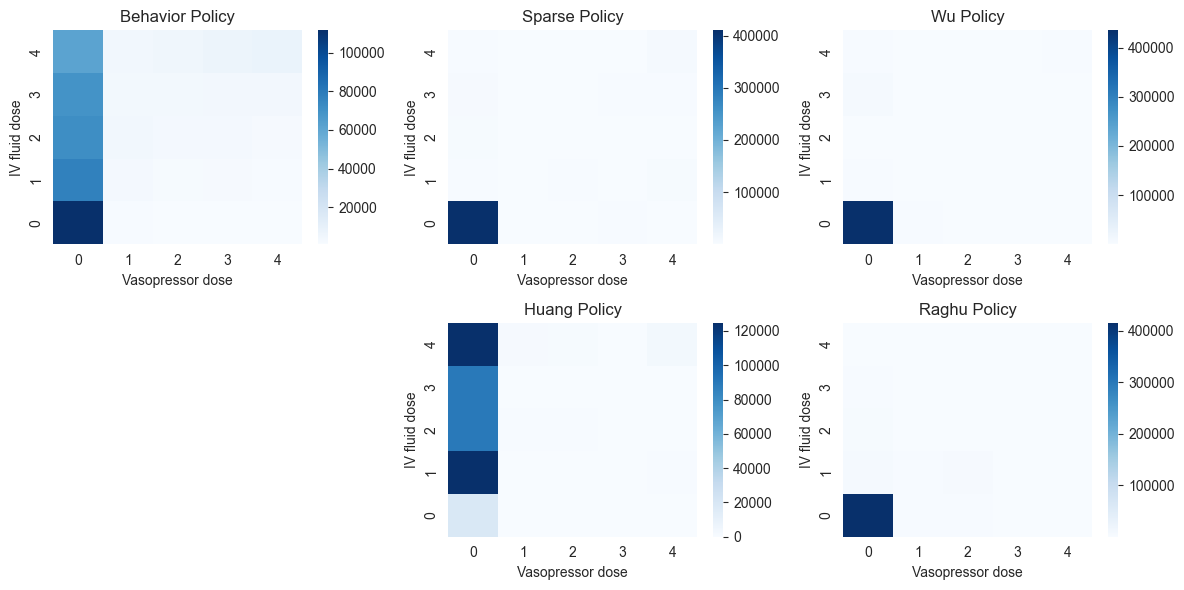

In [15]:
do_reward_fn_count_plots(actual_counts, sparse_counts, wu_counts, yong_counts, raghu_counts)

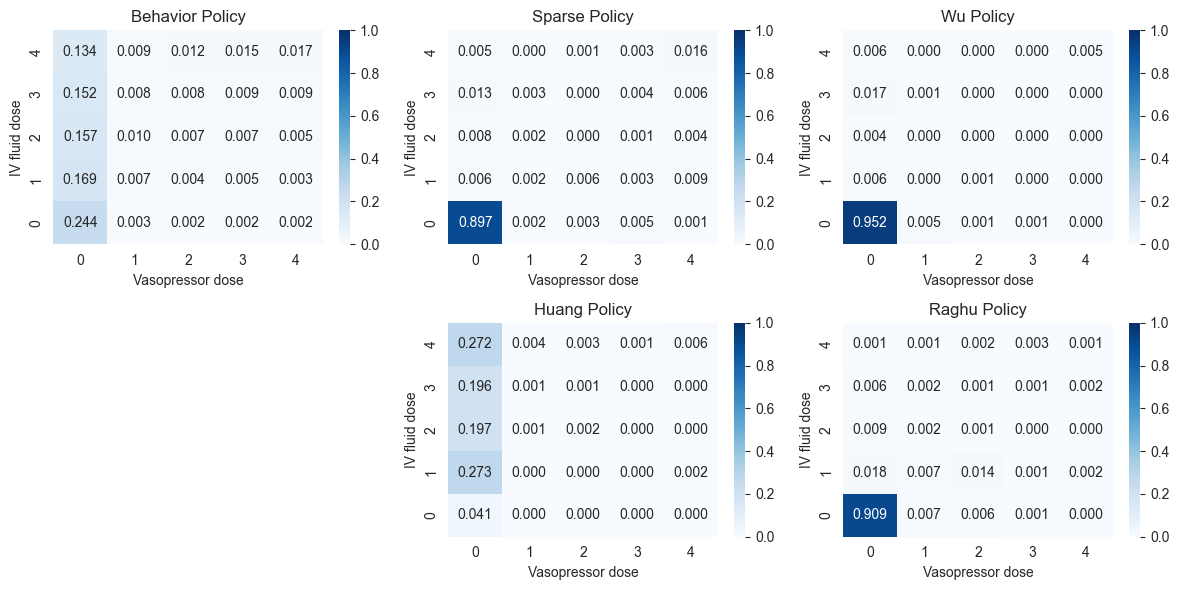

In [21]:
# normalize action counts so we can present action percentages
actual_counts_norm = actual_counts / actual_counts.sum()
sparse_counts_norm = sparse_counts / sparse_counts.sum()
wu_counts_norm = wu_counts / wu_counts.sum()
yong_counts_norm = yong_counts / yong_counts.sum()
raghu_counts_norm = raghu_counts / raghu_counts.sum()
do_reward_fn_count_plots(actual_counts_norm, sparse_counts_norm, wu_counts_norm, yong_counts_norm, raghu_counts_norm, vmin=0.0, vmax=1.0)

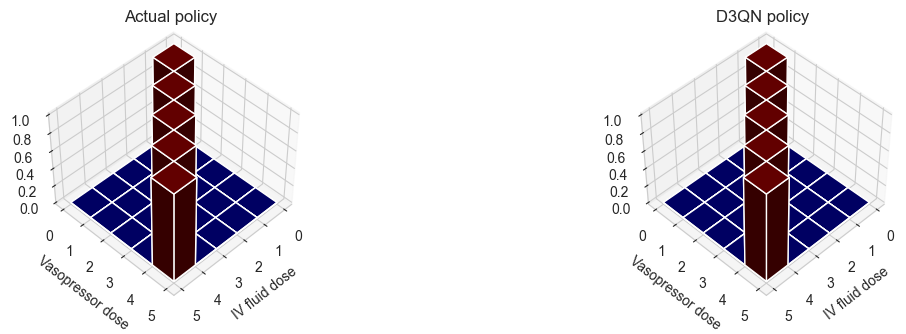

In [108]:
do_discrete_action_count_3d_plots(np.eye(5), np.eye(5))

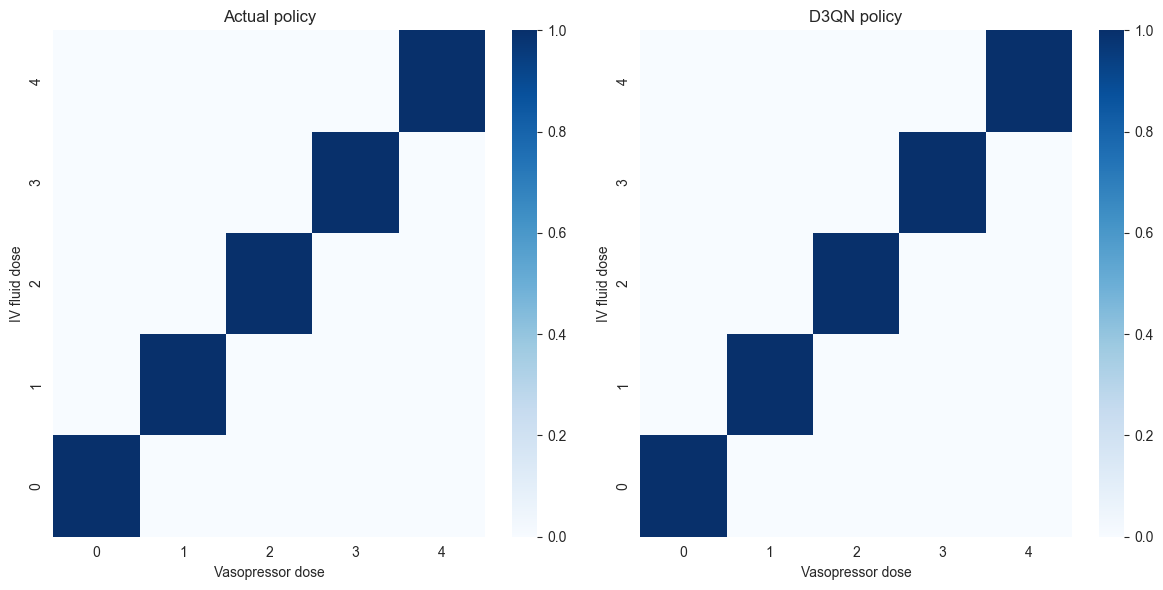

In [112]:
do_discrete_action_count_plots_v2(np.eye(5), np.eye(5))

2024/05/27 17:40:16 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 17:40:16 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 17:40:17 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 17:40:18 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 17:40:19 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 17:40:19 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 17:40:20 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 17:40:20 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed 

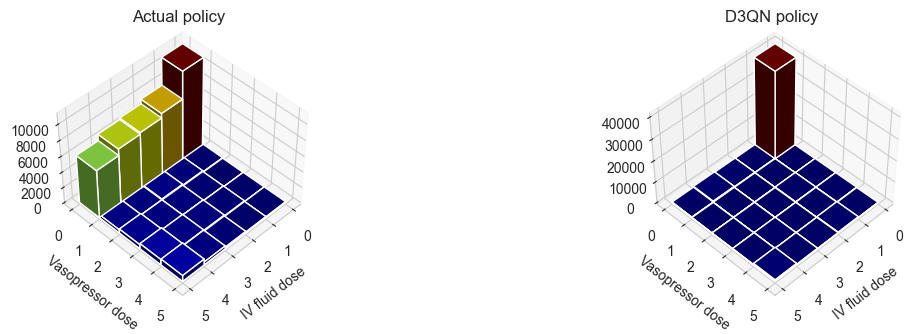

In [109]:
compute_and_3d_plot_mean_discrete_action_counts('sparse', reward_fn_details_dict)

2024/05/27 18:06:45 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:06:45 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:06:46 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:06:47 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:06:48 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:06:49 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:06:50 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:06:51 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed 

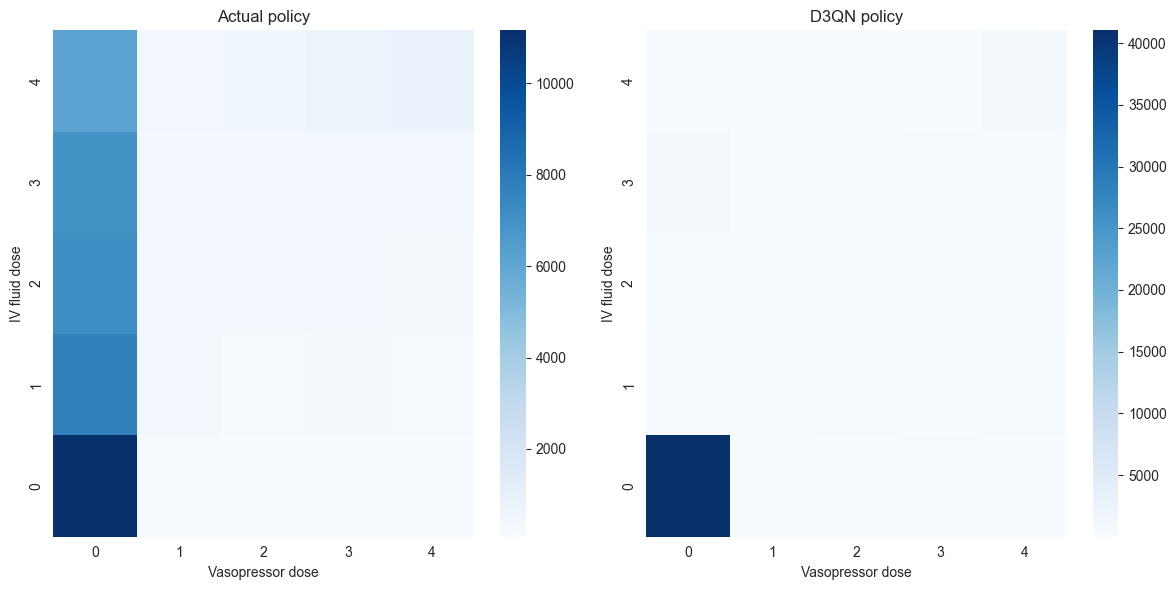

In [113]:
compute_and_plot_mean_discrete_action_counts('sparse', reward_fn_details_dict)

2024/05/27 18:09:39 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:09:40 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:09:41 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:09:42 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:09:42 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:09:42 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:09:42 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:09:42 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed 

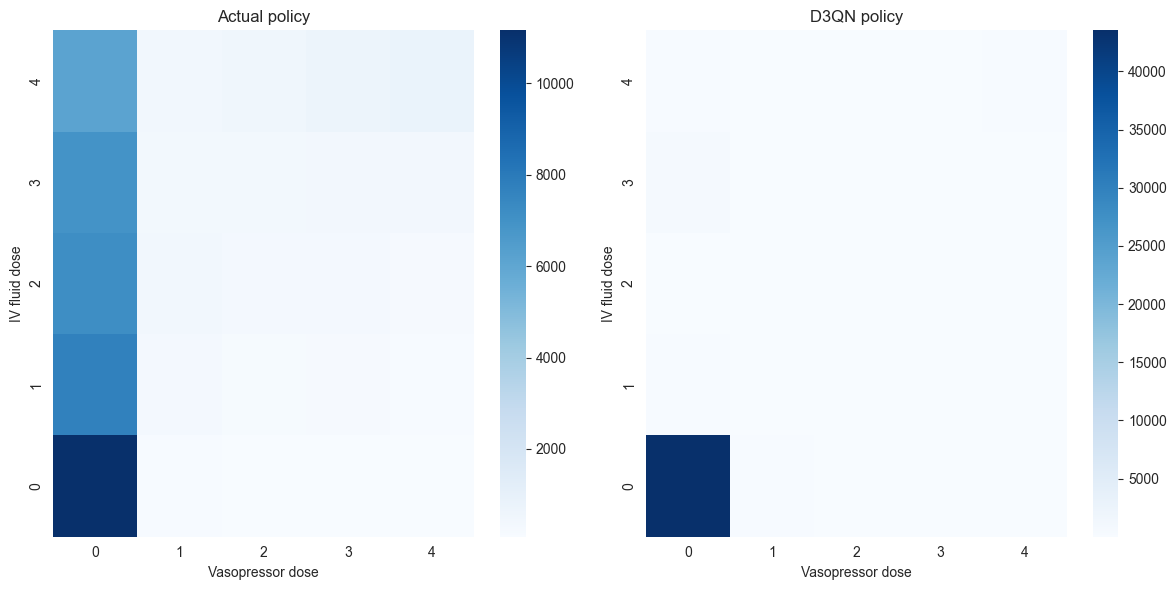

In [114]:
compute_and_plot_mean_discrete_action_counts('wu', reward_fn_details_dict)

2024/05/27 18:12:30 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:12:30 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:12:32 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:12:32 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:12:33 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:12:33 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:12:33 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:12:33 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed 

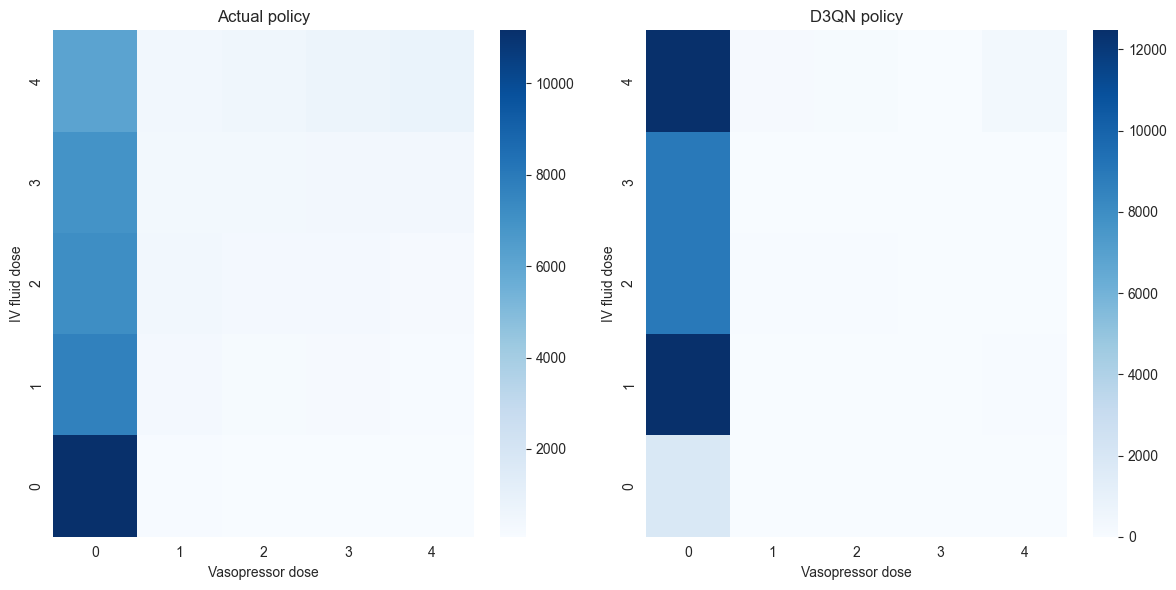

In [115]:
compute_and_plot_mean_discrete_action_counts('yong', reward_fn_details_dict)

2024/05/27 18:15:12 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:15:13 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:15:15 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:15:15 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:15:15 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:15:15 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:15:16 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/27 18:15:16 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed 

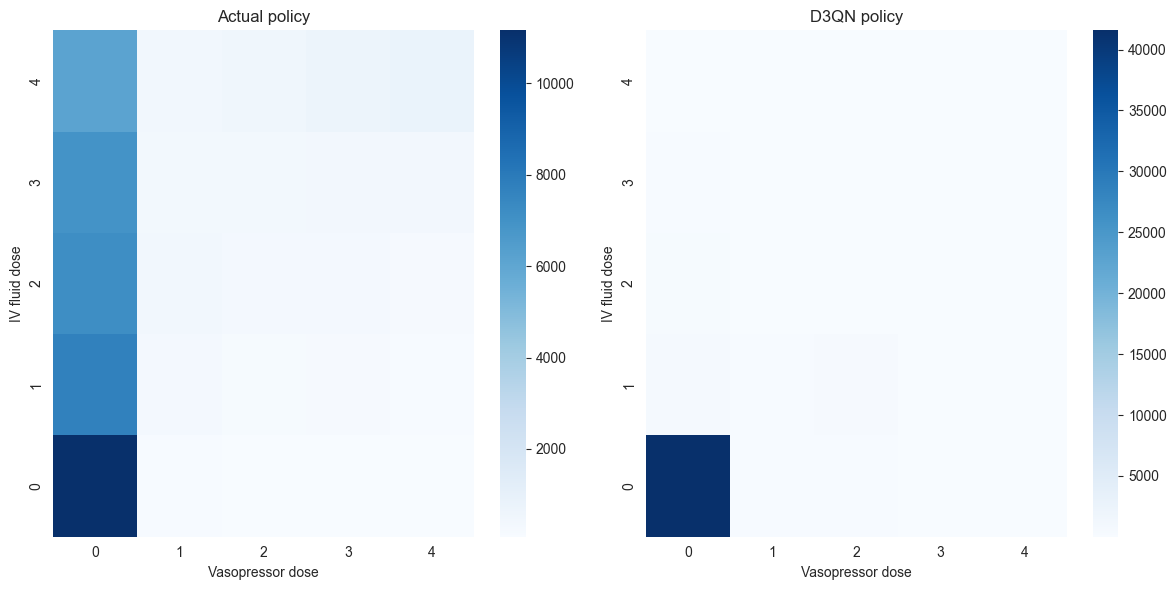

In [116]:
compute_and_plot_mean_discrete_action_counts('raghu', reward_fn_details_dict)

2024/05/24 15:17:25 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/24 15:17:38 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/24 15:17:39 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/24 15:17:40 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/24 15:17:41 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/24 15:17:41 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/24 15:17:41 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed PyTorch version '2.0.1'
2024/05/24 15:17:41 WARNING mlflow.pytorch: Stored model version '2.0.1+cu117' does not match installed 

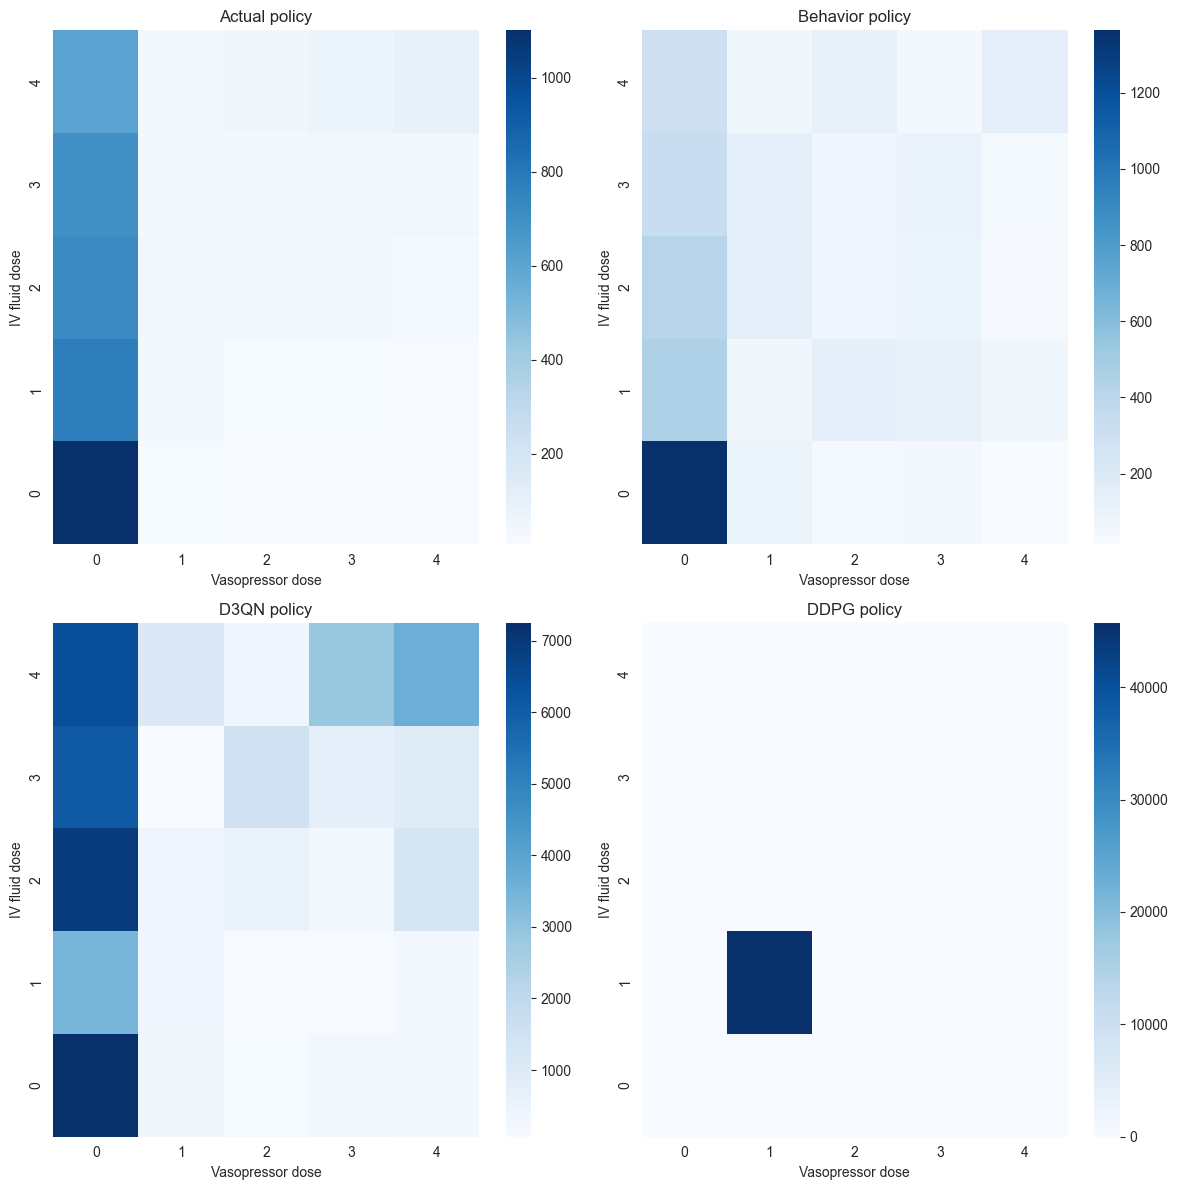

In [11]:
compute_and_plot_mean_discrete_action_counts('peng', reward_fn_details_dict)